📤 Faz upload do dataset (pode ser .zip ou .csv)


Saving dataset_angola.csv to dataset_angola (4).csv
✅ Dataset carregado: dataset_angola (4).csv
Espécies disponíveis: ['Turaco-crista-vermelha' 'Geneta-angolana' 'Sol-pássaro-de-Anchieta'
 'Rã-verde-africana' 'Hoopoe-comum' 'Angolan African dormouse'
 'Huambo Cisticola' 'Jacaré-do-Nilo' 'Palanca-negra-gigante'
 'Águia-pesqueira-africana']

📸 Faz upload de uma imagem de espécie (jpg/png)


Saving images (11).jpeg to images (11) (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 Predição (imagem): Águia-pesqueira-africana

🎙️ Faz upload de um ficheiro de áudio (.wav ou .mp3)


Saving XC559309 - felosa-europeia - Phylloscopus collybita collybita.mp3 to XC559309 - felosa-europeia - Phylloscopus collybita collybita (3).mp3


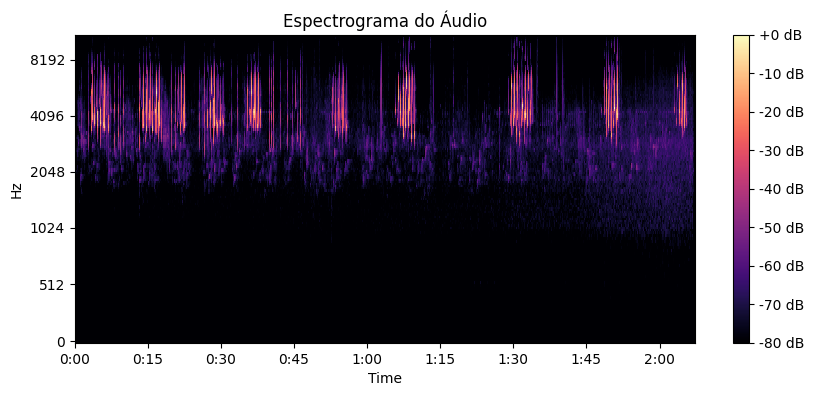

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
🔊 Predição (áudio): Águia-pesqueira-africana

🤖 Consultando o modelo BioLingo...

🦜 Resposta do BioLingo:
Com base na fauna angolana, a espécie mais provável referida como **"Águia-pesqueira-africana"** é, com alta probabilidade, o **Pescador-real-africano**, cujo nome científico é *Haliaeetus vocifer*, também conhecido como **Águia-pesqueira africana** ou **Águia-pesqueira de vozeiro**.

### Confirmação com base na fauna de Angola:

- **Presença em Angola**: Sim, o *Haliaeetus vocifer* está presente em várias regiões de Angola, especialmente em zonas com corpos de água permanentes — rios, lagos e áreas húmidas — como o rio Kwanza, rio Cuanza, sistema do Okavango (no extremo leste) e outras bacias fluviais.
  
- **Características distintivas**:
  - Plumagem branca na cabeça, peito e cauda, com contraste com as asas escuras.
  - Bico amarelo forte e curvado, adaptado para capturar peixes.
  - Chamado característico e estridente, que dá origem ao no

In [12]:
# ============================================================
# 🌍 BioLingo - Identificação de Espécies (Imagem + Áudio)
# ============================================================

# 1️⃣ Instalar dependências
!pip install tensorflow pandas scikit-learn librosa pillow matplotlib openai

# 2️⃣ Importações
import os, numpy as np, pandas as pd, librosa, librosa.display, matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
from io import BytesIO
import zipfile, requests
from google.colab import files
from openai import OpenAI

# ============================================================
# 3️⃣ Configuração
# ============================================================
os.environ["BIOLINGO_API_KEY"] = "sk-865e2f5d74454da8926d27e093eba545"

client = OpenAI(
    api_key=os.getenv("BIOLINGO_API_KEY"),
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1"
)

# ============================================================
# 4️⃣ Upload do dataset (ZIP ou CSV)
# ============================================================
print("📤 Faz upload do dataset (pode ser .zip ou .csv)")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]

# Verifica tipo de ficheiro
if dataset_path.endswith(".zip"):
    print("📦 Ficheiro ZIP detectado, a extrair...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
        extracted = zip_ref.namelist()
        print("📂 Conteúdo extraído:", extracted)
        csv_candidates = [f for f in extracted if f.endswith(".csv")]
        csv_path = os.path.join("/content", csv_candidates[0]) if csv_candidates else None
elif dataset_path.endswith(".csv"):
    csv_path = dataset_path
else:
    raise ValueError("Por favor envia um ficheiro .csv ou .zip contendo o dataset.")

# Ler CSV com tolerância de codificação
try:
    df = pd.read_csv(csv_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding="latin1")

print("✅ Dataset carregado:", csv_path)
print("Espécies disponíveis:", df["nome_comum"].unique())

# ============================================================
# 5️⃣ Upload e classificação de IMAGEM
# ============================================================
print("\n📸 Faz upload de uma imagem de espécie (jpg/png)")
img_upload = files.upload()
img_path = list(img_upload.keys())[0]

# Pré-processar imagem
img = Image.open(img_path).resize((224,224))
img_array = np.expand_dims(np.array(img)/255.0, axis=0)

# Modelo base EfficientNet (Transfer Learning simulado)
base_model = EfficientNetB0(include_top=False, input_shape=(224,224,3),
                             weights="imagenet", pooling="avg")

model_img = Sequential([
    base_model,
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dense(len(df["nome_comum"].unique()), activation="softmax")
])

# Simular predição
pred_img = model_img.predict(img_array)
predicted_label_img = df["nome_comum"].iloc[np.argmax(pred_img)]
print(f"🔍 Predição (imagem): {predicted_label_img}")

# ============================================================
# 6️⃣ Upload e classificação de ÁUDIO
# ============================================================
print("\n🎙️ Faz upload de um ficheiro de áudio (.wav ou .mp3)")
audio_upload = files.upload()
audio_path = list(audio_upload.keys())[0]

# Converter áudio em espectrograma
y, sr = librosa.load(audio_path, sr=22050)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('Espectrograma do Áudio')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Pré-processar espectrograma
mel_img = np.expand_dims(np.expand_dims(mel_db, axis=-1), axis=0)

# CNN simples para espectrograma
model_audio = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(mel_db.shape[0], mel_db.shape[1], 1)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(df["nome_comum"].unique()), activation='softmax')
])

pred_audio = model_audio.predict(mel_img)
predicted_label_audio = df["nome_comum"].iloc[np.argmax(pred_audio)]
print(f"🔊 Predição (áudio): {predicted_label_audio}")

# ============================================================
# 7️⃣ Verificação e Identificação
# ============================================================
descricao = (
    f"A imagem sugeriu: {predicted_label_img}. "
    f"O áudio sugeriu: {predicted_label_audio}. "
    "Confirma qual é a espécie mais provável com base em fauna angolana."
)

print("\n🤖 Consultando o modelo BioLingo...")
response = client.chat.completions.create(
    model="qwen-plus",
    messages=[
        {"role": "system", "content": "Tu és um biólogo especialista em espécies africanas e angolanas."},
        {"role": "user", "content": descricao}
    ]
)

print("\n🦜 Resposta do BioLingo:")
print(response.choices[0].message.content)
